<a href="https://colab.research.google.com/github/RamenSlayer/StableDiffusionNotebooks/blob/master/image_2_image_using_diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image2Image Pipeline for Stable Diffusion using 🧨 Diffusers 

This notebook shows how to create a custom `diffusers` pipeline for  text-guided image-to-image generation with Stable Diffusion model using  🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 

For a general introduction to the Stable Diffusion model please refer to this [colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).



In [ ]:
!nvidia-smi

Fri Dec  9 11:17:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install diffusers transformers ftfy accelerate
!pip install -qq "ipywidgets>=7,<8"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 502 kB 7.0 MB/s 
     |████████████████████████████████| 5.8 MB 62.4 MB/s 
     |████████████████████████████████| 53 kB 1.4 MB/s 
     |████████████████████████████████| 182 kB 53.4 MB/s 
     |████████████████████████████████| 7.6 MB 32.1 MB/s 
     |████████████████████████████████| 1.6 MB 6.5 MB/s 


You need to accept the model license before downloading or using the weights. By default we're using `v1-5`, so you'll need to  visit [its card](https://huggingface.co/runwayml/stable-diffusion-v1-5), read the license and tick the checkbox if you agree. 

Other models I suggest are (copy the name to model_path 2 blocks below):

[hakurei/waifu-diffusion](https://huggingface.co/hakurei/waifu-diffusion)

[CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)

[Linaqruf/anything-v3.0](https://huggingface.co/Linaqruf/anything-v3.0)


You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work. For more information on access tokens, please refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).

In [ ]:
from huggingface_hub import notebook_login

notebook_login() # don't run if using anything stable diffusion 1.4 or 1.5

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


## Image2Image pipeline.

In [ ]:
import inspect
import warnings
from typing import List, Optional, Union

import torch
from torch import autocast
from tqdm.auto import tqdm

from diffusers import StableDiffusionImg2ImgPipeline

Load the pipeline

In [ ]:
device = "cuda"
model_path = "runwayml/stable-diffusion-v1-5"

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    revision="fp16", # comment if using alternative models
    torch_dtype=torch.float16,
    use_auth_token=True # comment if using alternative models
)
pipe = pipe.to(device)

def dummy_checker(images, **kwargs):
  return images, False

pipe.safety_checker = dummy_checker

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.70k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/284 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/636 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/822 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/609 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Download an initial image and preprocess it so we can pass it to the pipeline.

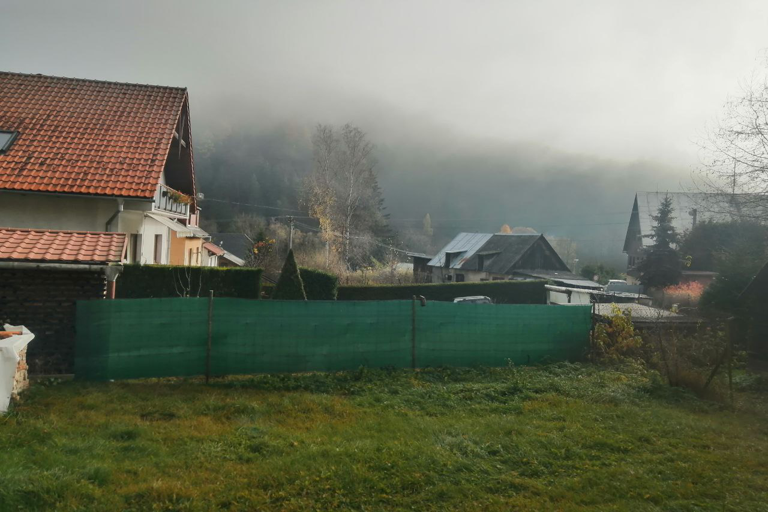

In [ ]:
from PIL import Image

img_path = "/content/images/grass.jpg"
init_img = Image.open(img_path).convert("RGB")
init_img = init_img.resize((768, 512))
init_img

Define the prompt and run the pipeline.

In [ ]:
prompt = "A 3d render of a village"

Here, `strength` is a value between 0.0 and 1.0, that controls the amount of noise that is added to the input image. Values that approach 1.0 allow for lots of variations but will also produce images that are not semantically consistent with the input.

In [ ]:
generator = torch.Generator(device=device).manual_seed(1024)
with autocast("cuda"):
    image = pipe(prompt=prompt,
                 image=init_img, # change image to init_image if recieving error
                 strength=0.75,
                 guidance_scale=7.5, 
                 generator=generator,
                 ).images[0]



  0%|          | 0/37 [00:00<?, ?it/s]

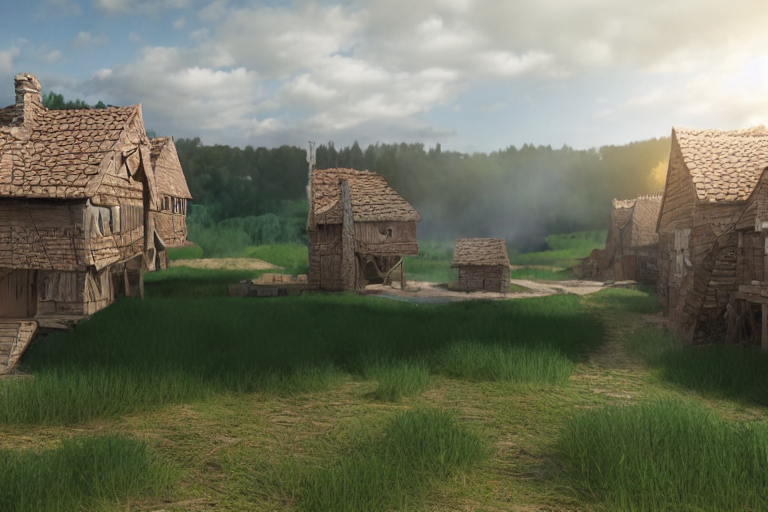

In [ ]:
image

In [ ]:
with autocast("cuda"):
    image = pipe(prompt=prompt, init_image=init_img, strength=0.5, guidance_scale=7.5, generator=generator).images[0]

  0%|          | 0/26 [00:00<?, ?it/s]

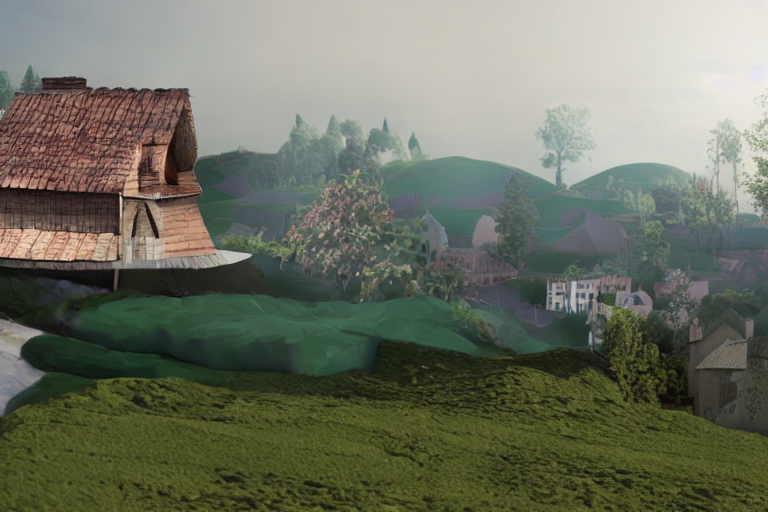

In [ ]:
image

As you can see, when using a lower value for `strength`, the generated image is more closer to the original `init_image`


Now using [LMSDiscreteScheduler](https://huggingface.co/docs/diffusers/api/schedulers#diffusers.LMSDiscreteScheduler)

In [ ]:
from diffusers import LMSDiscreteScheduler

lms = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear")
pipe.scheduler = lms

In [ ]:
generator = torch.Generator(device=device).manual_seed(1024)
with autocast("cuda"):
    image = pipe(prompt=prompt, init_image=init_img, strength=0.75, guidance_scale=7.5, generator=generator).images[0]

  0%|          | 0/37 [00:00<?, ?it/s]

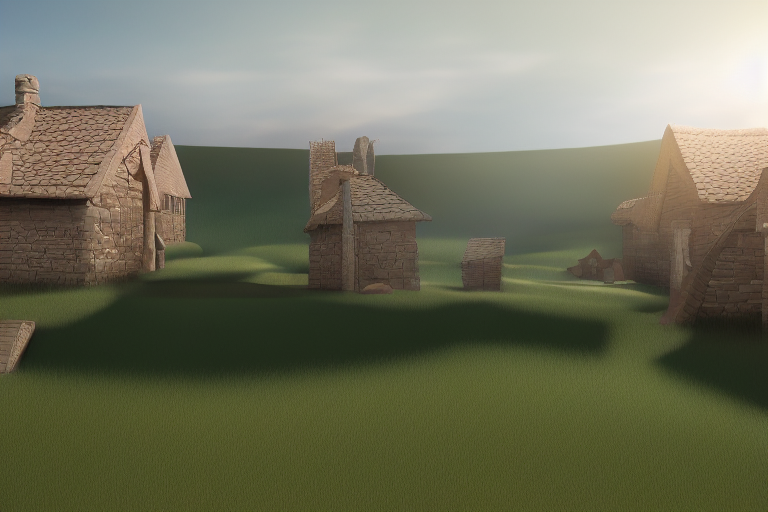

In [ ]:
image